In [3]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed 
from numba import jit

from sklearn.linear_model import LinearRegression
import scipy.linalg
from sklearn import linear_model
import sklearn.linear_model as skl
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold, ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

from imageio import imread

In [52]:
# Define the Franke Fumction
def frankeFunction(x1,x2,sig2):
    noise = np.random.normal(0,sig2,x1.shape)
    term1 = 0.75*np.exp(-(0.25*(9*x1-2)**2) - 0.25*((9*x2-2)**2))
    term2 = 0.75*np.exp(-((9*x1+1)**2)/49.0 - 0.1*(9*x2+1))
    term3 = 0.5*np.exp(-(9*x1-7)**2/4.0 - 0.25*((9*x2-3)**2))
    term4 = -0.2*np.exp(-(9*x1-4)**2 - (9*x2-7)**2)
    return term1 + term2 + term3 + term4 + noise

# Create the data points in mesh grid form
def createDataPoints(n, sig2):
    x1 = np.arange(0, 1, 1/n)
    x2 = np.arange(0, 1, 1/n)
#     x1 = np.sort(np.random.uniform(0, 5, n))
#     x2 = np.sort(np.random.uniform(0, 5, n))
    x1_d, x2_d = np.meshgrid(x1,x2)
    y_d = frankeFunction(x1_d,x2_d,sig2)
    return x1_d, x2_d, y_d.ravel()

# Create the design matrix with all possible combinations
@jit
def createDesignMatrix(x1, x2, n):
    if len(x1.shape) > 1:
        x1 = np.ravel(x1)
        x2 = np.ravel(x2)

    N = len(x1)
    p = int((n+1)*(n+2)/2)
    X = np.ones((N,p))

    for i in range(1, n+1):
        q = int(i*(i+1)/2)
        for j in range(i+1):
            X[:,q+j] = (x1**(i-j))*(x2**j)
    return X

# Predict the outcome using matrix inversion
def predict(X, y_data):
    beta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y_data)
    y_tilde = X @ beta
    return y_tilde, beta

# Calculate the mean square error (MSE)
def MSE(y_data, y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

# Calculate the coefficient of determination (R2)
def R2(y_data, y_model):
    n = np.size(y_data)
    return 1 - np.sum((y_data-y_model)**2)/np.sum((y_data-(np.sum(y_data)/n))**2)

#Scale the data and split them for training and testing
def Scale(X_train, X_test):
    XX = np.copy(X_test)
    if X_train.shape[1] > 1:
        scaler = StandardScaler()
        scaler.fit(X_train[:,1:])
        X_train[:,1:] = scaler.transform(X_train[:,1:])
        XX[:,1:] = scaler.transform(XX[:,1:])  
    return X_train, XX#, y_train[:, np.newaxis], y_test[:, np.newaxis]

# Calculate the confidence interval of parameters Beta's
def CIBeta(X, Beta):
    varBeta = np.diagonal(np.linalg.pinv(X.T @ X)*sig2)
#     print(((X.T @ X)))
    print(varBeta.shape)
    print(Beta.shape)
    stdBeta = np.sqrt(varBeta)
    errorBeta = 1.645*stdBeta
    return errorBeta

# I cannot get this function to work with X_train
def SVDinv(A):
    U, s, VT = np.linalg.svd(A)
    print(A.shape)
    print(U.shape)
    print(s.shape)
    print(VT.shape)
    S = np.diag(s)
    UT = np.transpose(U)
    V = np.transpose(VT)
    invS = np.linalg.inv(S)
    #print(np.matmul(V,np.matmul(invD,UT)).shape)
    return np.matmul(V,np.matmul(invS,UT))
  
def olsRegression(X_train,X_test,y_train,y_test, plot):
    
    beta = np.linalg.pinv(X_train.T.dot(X_train)).dot(X_train.T).dot(y_train)
    y_tilde = (X_train @ beta)
    y_pred = (X_test @ beta)

    if plot:
        ax0 = plt.figure(0)
        # plt.plot(X_train[:, 1], y_tilde, label="y_tilde")
        plt.plot(y_tilde[:10], label="y_tilde", color="red")
        plt.scatter(np.arange(10), y_train[:10], label="y_train", color="red")

        plt.plot(y_pred[:10], label="y_pred", color="green")
        plt.scatter(np.arange(10), y_test[:10], label="y_test", color='green')
        ax0.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.1, 0.9))


    print(f"The R2 value for a polynomial of order {degree}, OLS test: {R2(y_test, y_pred)}")
    print(f"The MSE value for a polynomial of order {degree}, OLS test: {MSE(y_test, y_pred)}")
    print(f"\nThe R2 value for a polynomial of order {degree}, OLS train: {R2(y_train, y_tilde)}")
    print(f"The MSE value for a polynomial of order {degree}, OLS train: {MSE(y_train, y_tilde)}")
    return beta

def ridgeRegression(X_train,X_test,y_train, y_test, nlambdas, plot):   
    N = np.size(X_train,1)
    I = np.eye(N)
    
    y_predict = np.zeros((nlambdas, X_test.shape[0]))
    y_ridgeSKL = np.zeros((nlambdas, X_test.shape[0]))
    # Decide which value of lambda to use
#     nlambdas = 4
    MSEPredict = np.zeros(nlambdas)
    MSETrain = np.zeros(nlambdas)
    MSEPredictSKL = np.zeros(nlambdas)
    lambdas = np.logspace(-4,1, nlambdas)
    for i in range(nlambdas):
        lmb = lambdas[i]
        # Add Ridge
        clf_ridge = skl.Ridge(alpha=lmb).fit(X_train,y_train)
        beta_ridge = np.linalg.inv(X_train.T @ X_train + lmb*I) @ X_train.T @ y_train
        # Make predictions
        y_tilde = X_train @ beta_ridge
        y_predict[i, :] = (X_test @ beta_ridge).squeeze()
        y_ridgeSKL[i, :] = clf_ridge.predict(X_test).squeeze()
        MSEPredict[i] = MSE(y_test, y_predict[i, :])
        MSETrain[i] = MSE(y_train, y_tilde)
        MSEPredictSKL[i] = MSE(y_test, y_ridgeSKL[i, :])
    if plot:
        plt.figure()
        plt.plot(np.log10(lambdas), MSETrain, label = 'MSE Ridge train')
        plt.plot(np.log10(lambdas), MSEPredict, 'r--', label = 'MSE Ridge Test')
        plt.plot(np.log10(lambdas), MSEPredictSKL, 'g--', label = 'MSE Ridge sickit-learn Test')
        plt.xlabel('log10(lambda)')
        plt.ylabel('MSE')
        plt.legend()
        plt.title(f'# Lambdas = {nlambdas}')
    return  y_predict

def lassoRegression(X_train,X_test,y_train, y_test, nlambdas, plot):
    N = np.size(X_train,1)
    I = np.eye(N)
    
    y_pred = np.zeros((nlambdas, X_test.shape[0]))
    # Decide which value of lambda to use
#     nlambdas = 4
    MSETrain = np.zeros(nlambdas)
    MSEPredictSKL = np.zeros(nlambdas)
    lambdas = np.logspace(-4,1, nlambdas)
    for i in range(nlambdas):
        lmb = lambdas[i]
        # Add Lasso
        clf_lasso = skl.Lasso(alpha=lmb).fit(X_train,y_train)
        # Make predictions
        y_tilde = clf_lasso.predict(X_train).squeeze()
        y_pred[i, :] = clf_lasso.predict(X_test).squeeze()
#         print("tilde", y_tilde.shape)
#         print("train", y_train.shape)
        MSETrain[i] = MSE(y_train.squeeze(), y_tilde)
        MSEPredictSKL[i] = MSE(y_test, y_pred[i, :])
    if plot:
        plt.figure()
        plt.plot(np.log10(lambdas), MSETrain, label = 'MSE Lasso train')
        plt.plot(np.log10(lambdas), MSEPredictSKL, 'g--', label = 'MSE Lasso Test')
        plt.xlabel('log10(lambda)')
        plt.ylabel('MSE')
        plt.legend()
        plt.title(f'# Lambdas = {nlambdas}')
    return  y_pred


def BootStrapping(method, x, y, nlambdas, maxdegree, n_boostraps):
    # Define empty arrays
    error = np.zeros((maxdegree+1, nlambdas))
    bias = np.zeros((maxdegree+1, nlambdas))
    variance = np.zeros((maxdegree+1, nlambdas))
    polydegree = np.zeros( maxdegree+1)

    if method == "ridge":
        LinReg = ridgeRegression
    elif method == "lasso":
        LinReg = lassoRegression
    for degree in range(maxdegree+1):
        X = createDesignMatrix(x[:,[0]],x[:,[1]],degree)  

        # Split and scale the design data
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
        y_train, y_test = y_train[:, np.newaxis], y_test[:, np.newaxis]

        y_pred = np.empty((nlambdas, y_test.shape[0], n_boostraps))

        for i in range(n_boostraps):
            x_, y_ = resample(X_train, y_train)

            x_, X_test2 = Scale(x_, X_test)
            
            
            y_pred[:, :, i] = LinReg(x_, X_test2,y_train,y_test, nlambdas, plot=False)

        polydegree[degree] = degree
        error[degree, :] = np.mean(np.mean((y_test - y_pred)**2, axis=1, keepdims=True), axis=2).squeeze()
        bias[degree, :] = np.mean( (y_test - np.mean(y_pred, axis=2, keepdims=True))**2, axis=1).squeeze()
        variance[degree, :] = np.mean( np.var(y_pred, axis=2, keepdims=True) , axis=1).squeeze()

        print("Polynomial degree:", degree)
        print("Error:", error[degree])
        print("Bias^2:", bias[degree])
        print("Var:", variance[degree])
        print('{} >= {} + {} = {}\n'.format(error[degree], bias[degree], variance[degree], bias[degree]+variance[degree]))

    lambdas = np.logspace(-4,1, nlambdas)

    for k in range(nlambdas):
        plt.subplot(2,2,k+1)
        plt.plot(polydegree, error[:, k], label="Error")
        plt.plot(polydegree, bias[:, k], label="bias")
        plt.plot(polydegree, variance[:, k], label="Variance")
        plt.legend()
        plt.title('lambda = %0.4f' %lambdas[k])
        plt.show()

def CrossValidation(method, X, y):

    if method == "ridge":
        LinReg = ridgeRegression
    elif method == "lasso":
        LinReg = lassoRegression
    elif method == "ols":
        LinReg = olsRegression
        
    for k in K:

        #Split data set into k parts
        splitXData = np.array(np.split(X,k))
        splitYData = np.array(np.split(y,k))
        MSErrors = np.zeros((nlambdas, k))

        s0 = splitXData.shape[0]
        s1 = splitXData.shape[1]

        y_pred = np.empty((nlambdas, s1))

        for i in range(0,k):
            mask = np.ones(k)
            mask[i]=0
            X_train = splitXData[mask==1].reshape(((s0-1)*s1,-1))
            X_test = splitXData[mask==0].squeeze()
            X_train, X_test = Scale(X_train, X_test)

            y_train = splitYData[mask==1].reshape(((s0-1)*s1,1))
            y_test = np.swapaxes(splitYData[mask==0], 0, 1)

            y_pred = LinReg(X_train, X_test,y_train,y_test, nlambdas, plot=False)

            MSErrors[:, i] = np.mean((y_test.squeeze() - y_pred)**2, keepdims=True, axis=1).squeeze()
        MSError = np.mean(MSErrors, axis=1)

        print("%s fold MSE:"% k, MSError)


a) OLS

(10, 10)
(100,)
The R2 value for a polynomial of order 4, OLS test: 0.7100641552841912
The MSE value for a polynomial of order 4, OLS test: 0.016359689892291203

The R2 value for a polynomial of order 4, OLS train: 0.9103736003624019
The MSE value for a polynomial of order 4, OLS train: 0.008989271303798804
(15,)
(15,)

The 90% confidence interval for beta_2 is -0.3901803975071598 ⟷ 2.353687494317903


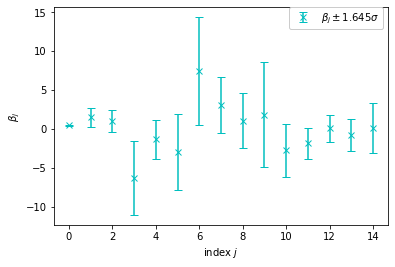

In [49]:
np.random.seed(2020)

sig2 = 0.1 # noise variance
degree = 4 # polynomial degree
n = 10 # number of data points for each feature
x1, x2, y = createDataPoints(n, sig2)
print(x1.shape)
print(y.shape)
X = createDesignMatrix(x1,x2,degree)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
X_train, X_test = Scale(X_train, X_test)

beta = olsRegression(X_train, X_test, y_train, y_test, False)

# Calculate the confidence interval of the 'p' parameters beta
errorBeta = CIBeta(X_train, beta)

# Print an example of a confidence interval
print(f"\nThe 90% confidence interval for beta_2 is {beta[2]-errorBeta[2]} ⟷ {beta[2]+errorBeta[2]}")

# Plot the Confidence Intervals for the betas
ax1 = plt.figure(1)
plt.errorbar(np.arange(len(beta)), beta, errorBeta, fmt='cx', capsize=4, label=r"$\beta_j \pm 1.645 \sigma$")
plt.xlabel("index $j$")
plt.ylabel(r"$\beta_j $")
ax1.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(0.9, 0.9))

(10, 7)


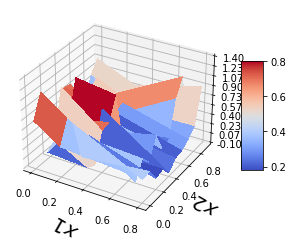

(10, 7)
(70,)


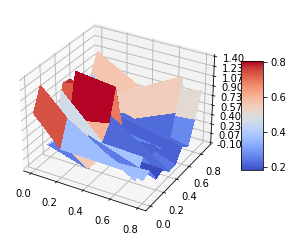

In [19]:
SS = ShuffleSplit(n_splits=1, test_size=0.3)
SS.get_n_splits(x1, x2)
train_index, _ = next(SS.split(x1, x2))

st = 7

x1_plot = x1[:,train_index[:st]]
x2_plot = x2[:,train_index[:st]] 
# print(x1_plot)
print(x2_plot.shape)

fig = plt.figure()
ax = fig.gca(projection='3d')
# print(y_tilde)

# Plot the surface.
surf = ax.plot_surface(x1_plot, x2_plot, y_tilde[:70].reshape((10, st)), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel('$x1$', fontsize=20, rotation=150)
ax.set_ylabel('$x2$', fontsize=20, rotation=150)
ax.set_zlabel('$y$', fontsize=20, rotation=150)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

fig2 = plt.figure()
ax2 = fig2.gca(projection='3d')

print(x1_plot.shape)
print(y_train.shape)
# Plot the surface.
surf2 = ax2.plot_surface(x1_plot, x2_plot, y_train[:70].reshape((10, st)), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax2.set_zlim(-0.10, 1.40)
ax2.zaxis.set_major_locator(LinearLocator(10))
ax2.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig2.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

b)

Polynomial degree: 0
Error: 0.09304829270052933
Bias^2: 0.09204223755982804
Var: 0.001006055140701291
0.09304829270052933 >= 0.09204223755982804 + 0.001006055140701291 = 0.09304829270052933

Polynomial degree: 1
Error: 0.038339460303301216
Bias^2: 0.037013985755732975
Var: 0.0013254745475682573
0.038339460303301216 >= 0.037013985755732975 + 0.0013254745475682573 = 0.03833946030330123

Polynomial degree: 2
Error: 0.02499229777465326
Bias^2: 0.022727349793554476
Var: 0.0022649479810987797
0.02499229777465326 >= 0.022727349793554476 + 0.0022649479810987797 = 0.024992297774653255

Polynomial degree: 3
Error: 0.014563528506379252
Bias^2: 0.01220963074962925
Var: 0.002353897756750002
0.014563528506379252 >= 0.01220963074962925 + 0.002353897756750002 = 0.014563528506379252

Polynomial degree: 4
Error: 0.015617868631644053
Bias^2: 0.008199919525022263
Var: 0.007417949106621792
0.015617868631644053 >= 0.008199919525022263 + 0.007417949106621792 = 0.015617868631644057

Polynomial degree: 5
Error

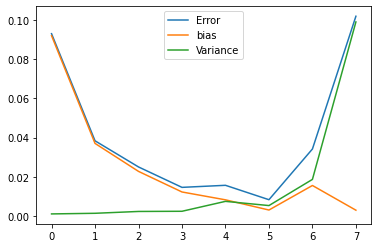

In [4]:
np.random.seed(26)
# print(np.random.get_state()[1][0])

sig2 = 0.01 # noise variance
n = 10 # number of data points for each feature
n_boostraps = 200 # number of bootstraps 
maxdegree = 7 # maximum polynomial degree

for n in range(10,11):
#     print(n)
    # Make data set.
    x1, x2, y = createDataPoints(n, sig2)
    x = np.swapaxes(np.stack((x1.ravel(),x2.ravel())),0,1)
#     print(x.shape)

    # Define empty arrays
    error = np.zeros(maxdegree+1)
    bias = np.zeros(maxdegree+1)
    variance = np.zeros(maxdegree+1)
    polydegree = np.zeros(maxdegree+1)


    for degree in range(maxdegree+1):
#         print("\n", degree, "\n")
        X = createDesignMatrix(x[:,[0]],x[:,[1]],degree)  
        
        # Split and scale the design data
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
        y_train, y_test = y_train[:, np.newaxis], y_test[:, np.newaxis]
#         X_test.flags.writeable = False
        y_pred = np.empty((y_test.shape[0], n_boostraps))
        for i in range(n_boostraps):
#             print(i)
            x_, y_ = resample(X_train, y_train)
#             print("X_test before", X_test[:1, :])

            x_, X_test2 = Scale(x_, X_test)
#             print("X_test after", X_test2[:1, :])

            beta = np.linalg.pinv(x_.T.dot(x_)).dot(x_.T).dot(y_)
            y_pred[:, i] = (X_test2 @ beta).squeeze()

        polydegree[degree] = degree
        error[degree] = np.mean( np.mean((y_test - y_pred)**2, axis=1, keepdims=True) )
        bias[degree] = np.mean( (y_test - np.mean(y_pred, axis=1, keepdims=True))**2 )
        variance[degree] = np.mean( np.var(y_pred, axis=1, keepdims=True) )
        print("Polynomial degree:", degree)
        print("Error:", error[degree])
        print("Bias^2:", bias[degree])
        print("Var:", variance[degree])
        print('{} >= {} + {} = {}\n'.format(error[degree], bias[degree], variance[degree], bias[degree]+variance[degree]))

    plt.plot(polydegree, error, label="Error")
    plt.plot(polydegree, bias, label="bias")
    plt.plot(polydegree, variance, label="Variance")
    plt.legend()
    plt.show()

c)

In [5]:
np.random.seed(26)

sig2 = 0.01 # noise variance
n = 10 # number of data points for each feature
K = [5, 10]
degree = 7

x1, x2, y = createDataPoints(n, sig2)
x = np.swapaxes(np.stack((x1.ravel(),x2.ravel())),0,1)

X = createDesignMatrix(x[:,[0]],x[:,[1]],degree)  
p = np.random.permutation(X.shape[0])
X = X[p]
y = y[p]

print("Polynomial degree:", degree)

for k in K:

    #Split data set into k parts
    splitXData = np.array(np.split(X,k))
    splitYData = np.array(np.split(y,k))
    MSErrors = np.zeros(k)

    s0 = splitXData.shape[0]
    s1 = splitXData.shape[1]

    for i in range(0,k):
        mask = np.ones(k)
        mask[i]=0
        X_train = splitXData[mask==1].reshape(((s0-1)*s1,-1))
        X_test = splitXData[mask==0].squeeze()
        X_train, X_test = Scale(X_train, X_test)

        y_train = splitYData[mask==1].reshape(((s0-1)*s1,1))
        y_test = np.swapaxes(splitYData[mask==0], 0, 1)

        beta = np.linalg.pinv(X_train.T.dot(X_train)).dot(X_train.T).dot(y_train)
        y_pred = (X_test @ beta)

        MSErrors[i] = np.mean((y_test - y_pred)**2, keepdims=True)
#         print(MSErrors[i])
    MSError = np.mean(MSErrors)

    print("%s fold MSE:"% k, MSError)

Polynomial degree: 7
5 fold MSE: 0.0033216318833721213
10 fold MSE: 0.0020835870696384617


Compare our code for k-CV with that from scikit-learn

In [11]:
np.random.seed(26)

sig2 = 0.01 # noise variance
n = 10 # number of data points for each feature
K = [5, 10]
degree = 7

x1, x2, y = createDataPoints(n, sig2)
x = np.swapaxes(np.stack((x1.ravel(),x2.ravel())),0,1)

# X = createDesignMatrix(x[:,[0]],x[:,[1]],degree)  
# p = np.random.permutation(X.shape[0])
# X = X[p]
# y = y[p]

poly = PolynomialFeatures(degree = 7)

OLS = LinearRegression(fit_intercept=False)
X = poly.fit_transform(x)
X = X[p]
y = y[p]
estimated_mse_folds = cross_val_score(OLS, X, y[:, np.newaxis], scoring='neg_mean_squared_error', cv=10)
# cross_val_score return an array containing the estimated negative mse for every fold.
# we have to the the mean of every array in order to get an estimate of the mse of the model
estimated_mse_sklearn = np.mean(-estimated_mse_folds)

print(estimated_mse_sklearn)

0.0020835879224487116


d) Example of Ridge regression

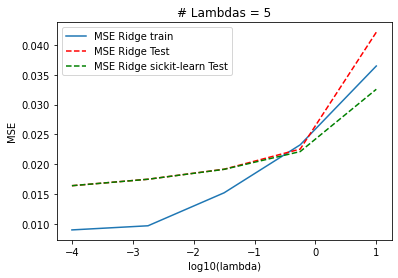

In [50]:
_ = ridgeRegression(X_train, X_test,y_train,y_test, nlambdas=5, plot=True)

d) Perform bootstrapping with ridge

Polynomial degree: 0
Error: [0.09202979 0.09202991 0.09203735 0.09533053]
Bias^2: [0.09202979 0.09202991 0.09203735 0.09533053]
Var: [0. 0. 0. 0.]
[0.09202979 0.09202991 0.09203735 0.09533053] >= [0.09202979 0.09202991 0.09203735 0.09533053] + [0. 0. 0. 0.] = [0.09202979 0.09202991 0.09203735 0.09533053]

Polynomial degree: 1
Error: [0.07982476 0.07982547 0.07986013 0.08426419]
Bias^2: [0.07662241 0.07662358 0.07667933 0.08186883]
Var: [0.00320235 0.0032019  0.00318081 0.00239535]
[0.07982476 0.07982547 0.07986013 0.08426419] >= [0.07662241 0.07662358 0.07667933 0.08186883] + [0.00320235 0.0032019  0.00318081 0.00239535] = [0.07982476 0.07982547 0.07986013 0.08426419]

Polynomial degree: 2
Error: [0.09814557 0.09813625 0.09777963 0.10297877]
Bias^2: [0.09218285 0.09218558 0.09231577 0.10060253]
Var: [0.00596272 0.00595067 0.00546386 0.00237624]
[0.09814557 0.09813625 0.09777963 0.10297877] >= [0.09218285 0.09218558 0.09231577 0.10060253] + [0.00596272 0.00595067 0.00546386 0.00237624] 

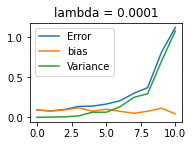

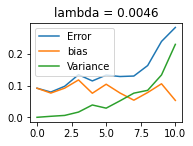

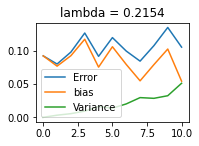

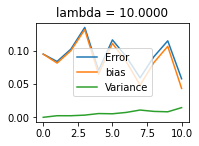

In [54]:
np.random.seed(26)
# print(np.random.get_state()[1][0])

sig2 = 0.01 # noise variance
n = 10 # number of data points for each feature
n_boostraps = 200 # number of bootstraps 
maxdegree = 5 # maximum polynomial degree
nlambdas = 4

# for  in range(10,11):
# Make data set.
x1, x2, y = createDataPoints(n, sig2)
x = np.swapaxes(np.stack((x1.ravel(),x2.ravel())),0,1)

BootStrapping("ridge", x, y, nlambdas=4, maxdegree=10, n_boostraps=200)

d) Perform cross validation on ridge regression

In [55]:
np.random.seed(26)

sig2 = 0.01 # noise variance
n = 10 # number of data points for each feature
K = [5, 10]
degree = 7
nlambdas = 4

x1, x2, y = createDataPoints(n, sig2)
x = np.swapaxes(np.stack((x1.ravel(),x2.ravel())),0,1)

X = createDesignMatrix(x[:,[0]],x[:,[1]],degree)  
p = np.random.permutation(X.shape[0])
X = X[p]
y = y[p]

print("Polynomial degree:", degree)

CrossValidation("ridge", X,y)

Polynomial degree: 7
5 fold MSE: [0.00396176 0.00575206 0.0097047  0.02142667]
10 fold MSE: [0.00364082 0.00385706 0.00920423 0.02012492]


e) Example of Lasso regression

/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.35400091920716426, tolerance: 0.0007020799606034237
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010383908829709743, tolerance: 0.0007020799606034237
  positive)


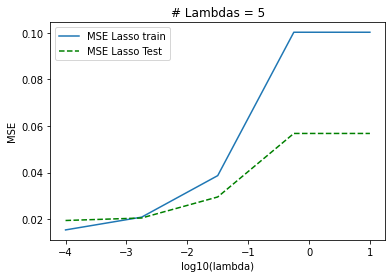

In [58]:
_ = lassoRegression(X_train, X_test,y_train, y_test, nlambdas=5, plot=True)

e) Performing bootstrapping with lasso regression

Polynomial degree: 0
Error: [0.09202978 0.09202978 0.09202978 0.09202978]
Bias^2: [0.09202978 0.09202978 0.09202978 0.09202978]
Var: [1.23259516e-32 1.23259516e-32 1.23259516e-32 1.23259516e-32]
[0.09202978 0.09202978 0.09202978 0.09202978] >= [0.09202978 0.09202978 0.09202978 0.09202978] + [1.23259516e-32 1.23259516e-32 1.23259516e-32 1.23259516e-32] = [0.09202978 0.09202978 0.09202978 0.09202978]

Polynomial degree: 1
Error: [0.07957564 0.07919638 0.07808794 0.07808794]
Bias^2: [0.07706716 0.07722118 0.07808794 0.07808794]
Var: [0.00250848 0.0019752  0.         0.        ]
[0.07957564 0.07919638 0.07808794 0.07808794] >= [0.07706716 0.07722118 0.07808794 0.07808794] + [0.00250848 0.0019752  0.         0.        ] = [0.07957564 0.07919638 0.07808794 0.07808794]

Polynomial degree: 2
Error: [0.09122453 0.08723244 0.08324201 0.08324201]
Bias^2: [0.08427892 0.08408411 0.08324201 0.08324201]
Var: [0.00694561 0.00314833 0.         0.        ]
[0.09122453 0.08723244 0.08324201 0.08324201] >

/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.38755886265243955, tolerance: 0.0005735288329492077
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.214274347130511, tolerance: 0.0005735288329492077
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7076356718524632, tolerance: 0.0005735288329492077
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objecti

/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.921228615269474, tolerance: 0.0005735288329492077
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.061414043961282694, tolerance: 0.0005735288329492077
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9036240542503098, tolerance: 0.0005735288329492077
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Object

/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5804381931087934, tolerance: 0.0005735288329492077
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.099505731321652, tolerance: 0.0005735288329492077
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4111631196475725, tolerance: 0.0005735288329492077
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objectiv

/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4175509888208846, tolerance: 0.0005735288329492077
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.14579066176854427, tolerance: 0.0005735288329492077
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.24515363834376425, tolerance: 0.0005735288329492077
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objec

Polynomial degree: 3
Error: [0.09010928 0.07953348 0.07543888 0.07543888]
Bias^2: [0.07635032 0.07518151 0.07543888 0.07543888]
Var: [1.37589603e-02 4.35197154e-03 3.08148791e-33 3.08148791e-33]
[0.09010928 0.07953348 0.07543888 0.07543888] >= [0.07635032 0.07518151 0.07543888 0.07543888] + [1.37589603e-02 4.35197154e-03 3.08148791e-33 3.08148791e-33] = [0.09010928 0.07953348 0.07543888 0.07543888]



/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7128638374019118, tolerance: 0.0006197531368735128
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.600335669974247, tolerance: 0.0006197531368735128
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6683585200407594, tolerance: 0.0006197531368735128
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objectiv

/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8007879304975285, tolerance: 0.0006197531368735128
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4325297372112693, tolerance: 0.0006197531368735128
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.67432244777966, tolerance: 0.0006197531368735128
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective

/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3768168259552074, tolerance: 0.0006197531368735128
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1476150066031012, tolerance: 0.0006197531368735128
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.067941043095545, tolerance: 0.0006197531368735128
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objectiv

/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5460037938717268, tolerance: 0.0006197531368735128
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2434841135717025, tolerance: 0.0006197531368735128
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8511543045269492, tolerance: 0.0006197531368735128
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objecti

/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6160189207807742, tolerance: 0.0006197531368735128
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1480660424292877, tolerance: 0.0006197531368735128
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3768343220226686, tolerance: 0.0006197531368735128
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objecti

/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9868348003499943, tolerance: 0.0006197531368735128
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.871190442633449, tolerance: 0.0006197531368735128
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8748584063798681, tolerance: 0.0006197531368735128
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objectiv

Polynomial degree: 4
Error: [0.09115396 0.0679581  0.06212313 0.06212313]
Bias^2: [0.06245901 0.06153115 0.06212313 0.06212313]
Var: [0.02869495 0.00642694 0.         0.        ]
[0.09115396 0.0679581  0.06212313 0.06212313] >= [0.06245901 0.06153115 0.06212313 0.06212313] + [0.02869495 0.00642694 0.         0.        ] = [0.09115396 0.0679581  0.06212313 0.06212313]



/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8758385224992764, tolerance: 0.0006413845406398307
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4133939436390006, tolerance: 0.0006413845406398307
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1189747206193275, tolerance: 0.0006413845406398307
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objecti

/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2967216136270943, tolerance: 0.0006413845406398307
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4200260134250988, tolerance: 0.0006413845406398307
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8972006545120275, tolerance: 0.0006413845406398307
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objecti

/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.780357566649334, tolerance: 0.0006413845406398307
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3541090147856916, tolerance: 0.0006413845406398307
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1692062600799642, tolerance: 0.0006413845406398307
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objectiv

/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4320021061065271, tolerance: 0.0006413845406398307
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4360910448244928, tolerance: 0.0006413845406398307
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9939220829362299, tolerance: 0.0006413845406398307
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objecti

/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4039982459193647, tolerance: 0.0006413845406398307
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9280795978764154, tolerance: 0.0006413845406398307
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5888583913522216, tolerance: 0.0006413845406398307
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objecti

Polynomial degree: 5
Error: [0.07055946 0.05757228 0.05172558 0.05172558]
Bias^2: [0.05058618 0.05221996 0.05172558 0.05172558]
Var: [1.99732774e-02 5.35232154e-03 3.08148791e-33 3.08148791e-33]
[0.07055946 0.05757228 0.05172558 0.05172558] >= [0.05058618 0.05221996 0.05172558 0.05172558] + [1.99732774e-02 5.35232154e-03 3.08148791e-33 3.08148791e-33] = [0.07055946 0.05757228 0.05172558 0.05172558]



/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8427229708739736, tolerance: 0.0005045528177034008
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5698442341409677, tolerance: 0.0005045528177034008
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5275093695382616, tolerance: 0.0005045528177034008
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objecti

/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4782570603963747, tolerance: 0.0005045528177034008
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9835994013427473, tolerance: 0.0005045528177034008
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1386205575953612, tolerance: 0.0005045528177034008
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objecti

/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.568985935348318, tolerance: 0.0005045528177034008
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8733834183082725, tolerance: 0.0005045528177034008
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8026132459547806, tolerance: 0.0005045528177034008
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objectiv

/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7006989045798206, tolerance: 0.0005045528177034008
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4902266292040713, tolerance: 0.0005045528177034008
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.277009302442624, tolerance: 0.0005045528177034008
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objectiv

/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0590268954925195, tolerance: 0.0005045528177034008
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1842743425496112, tolerance: 0.0005045528177034008
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5394883270508752, tolerance: 0.0005045528177034008
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objecti

Polynomial degree: 6
Error: [0.14990472 0.10984742 0.09802745 0.09802745]
Bias^2: [0.09381459 0.09788191 0.09802745 0.09802745]
Var: [5.60901224e-02 1.19655117e-02 2.77333912e-32 2.77333912e-32]
[0.14990472 0.10984742 0.09802745 0.09802745] >= [0.09381459 0.09788191 0.09802745 0.09802745] + [5.60901224e-02 1.19655117e-02 2.77333912e-32 2.77333912e-32] = [0.14990472 0.10984742 0.09802745 0.09802745]



/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.510814083608057, tolerance: 0.0005207341240551172
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0068412648809901, tolerance: 0.0005207341240551172
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3192178069974954, tolerance: 0.0005207341240551172
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objectiv

/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0829799809984924, tolerance: 0.0005207341240551172
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3802798733024488, tolerance: 0.0005207341240551172
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3394743243552623, tolerance: 0.0005207341240551172
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objecti

/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.706920024038824, tolerance: 0.0005207341240551172
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0218802608561557, tolerance: 0.0005207341240551172
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2539134280652002, tolerance: 0.0005207341240551172
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objectiv

/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3627544741307815, tolerance: 0.0005207341240551172
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8107825966339279, tolerance: 0.0005207341240551172
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.114758148635278, tolerance: 0.0005207341240551172
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objectiv

Polynomial degree: 7
Error: [0.11350066 0.09536628 0.09184674 0.09184674]
Bias^2: [0.09030775 0.08992205 0.09184674 0.09184674]
Var: [0.02319291 0.00544423 0.         0.        ]
[0.11350066 0.09536628 0.09184674 0.09184674] >= [0.09030775 0.08992205 0.09184674 0.09184674] + [0.02319291 0.00544423 0.         0.        ] = [0.11350066 0.09536628 0.09184674 0.09184674]



/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.340266370474141, tolerance: 0.0006116471395820334
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.322370558330228, tolerance: 0.0006116471395820334
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.534488123123684, tolerance: 0.0006116471395820334
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective 

/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3906222223236657, tolerance: 0.0006116471395820334
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1697172705150607, tolerance: 0.0006116471395820334
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.520351157520352, tolerance: 0.0006116471395820334
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objectiv

/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007133890249093611, tolerance: 0.0006116471395820334
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5703352331863183, tolerance: 0.0006116471395820334
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2734487941550996, tolerance: 0.0006116471395820334
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Obje

/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9385986255946188, tolerance: 0.0006116471395820334
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4105541957928431, tolerance: 0.0006116471395820334
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.747692378332277, tolerance: 0.0006116471395820334
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objectiv

/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4743023168402556, tolerance: 0.0006116471395820334
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4955592394610053, tolerance: 0.0006116471395820334
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2811156573452043, tolerance: 0.0006116471395820334
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objecti

Polynomial degree: 8
Error: [0.13375195 0.07954501 0.06560171 0.06560171]
Bias^2: [0.05874439 0.06214931 0.06560171 0.06560171]
Var: [7.50075591e-02 1.73956978e-02 3.08148791e-33 3.08148791e-33]
[0.13375195 0.07954501 0.06560171 0.06560171] >= [0.05874439 0.06214931 0.06560171 0.06560171] + [7.50075591e-02 1.73956978e-02 3.08148791e-33 3.08148791e-33] = [0.13375195 0.07954501 0.06560171 0.06560171]



/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4842143401694776, tolerance: 0.0005381520302126477
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1429919203725336, tolerance: 0.0005381520302126477
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3396747151206223, tolerance: 0.0005381520302126477
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objecti

/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.052342141734353, tolerance: 0.0005381520302126477
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2094222442464186, tolerance: 0.0005381520302126477
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.795241621025373, tolerance: 0.0005381520302126477
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective

/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1984832253832238, tolerance: 0.0005381520302126477
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1477396998586338, tolerance: 0.0005381520302126477
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1792957008465625, tolerance: 0.0005381520302126477
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objecti

/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3311657202787335, tolerance: 0.0005381520302126477
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1624699187079963, tolerance: 0.0005381520302126477
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3446286425233676, tolerance: 0.0005381520302126477
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objecti

/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.541163187755408, tolerance: 0.0005381520302126477
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0098660355064388, tolerance: 0.0005381520302126477
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6086312383814059, tolerance: 0.0005381520302126477
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objectiv

Polynomial degree: 9
Error: [0.14372473 0.09525276 0.08850769 0.08850769]
Bias^2: [0.0904593  0.08858857 0.08850769 0.08850769]
Var: [5.32654308e-02 6.66418538e-03 2.77333912e-32 2.77333912e-32]
[0.14372473 0.09525276 0.08850769 0.08850769] >= [0.0904593  0.08858857 0.08850769 0.08850769] + [5.32654308e-02 6.66418538e-03 2.77333912e-32 2.77333912e-32] = [0.14372473 0.09525276 0.08850769 0.08850769]



/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2552923739827044, tolerance: 0.000547749680471232
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015372070908536983, tolerance: 0.000547749680471232
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3780996943560717, tolerance: 0.000547749680471232
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objecti

/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5281333325832518, tolerance: 0.000547749680471232
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.256030150928181, tolerance: 0.000547749680471232
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3698554291509981, tolerance: 0.000547749680471232
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective d

/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5331217801449775, tolerance: 0.000547749680471232
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002050349337191726, tolerance: 0.000547749680471232
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3384478661318797, tolerance: 0.000547749680471232
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objectiv

/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3001564054068862, tolerance: 0.000547749680471232
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3162150211948986, tolerance: 0.000547749680471232
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3808729017778174, tolerance: 0.000547749680471232
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective 

/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6161934783717733, tolerance: 0.000547749680471232
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2309476932469208, tolerance: 0.000547749680471232
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006217455764732094, tolerance: 0.000547749680471232
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objecti

/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.035096991729472, tolerance: 0.000547749680471232
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3012890391628673, tolerance: 0.000547749680471232
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8372960434803645, tolerance: 0.000547749680471232
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective d

/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0477237821374832, tolerance: 0.000547749680471232
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9151219825936712, tolerance: 0.000547749680471232
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0823435434336672, tolerance: 0.000547749680471232
  positive)
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective 

Polynomial degree: 10
Error: [0.10853322 0.09046147 0.08670233 0.08670233]
Bias^2: [0.08732703 0.0860044  0.08670233 0.08670233]
Var: [0.02120619 0.00445707 0.         0.        ]
[0.10853322 0.09046147 0.08670233 0.08670233] >= [0.08732703 0.0860044  0.08670233 0.08670233] + [0.02120619 0.00445707 0.         0.        ] = [0.10853322 0.09046147 0.08670233 0.08670233]



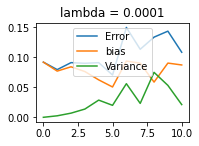

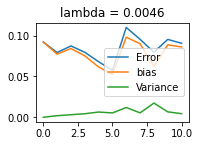

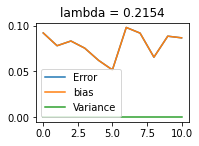

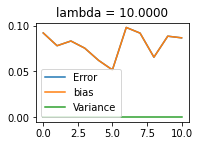

In [59]:
np.random.seed(26)
# print(np.random.get_state()[1][0])

sig2 = 0.01 # noise variance
n = 10 # number of data points for each feature
n_boostraps = 200 # number of bootstraps 
maxdegree = 5 # maximum polynomial degree
nlambdas = 4

# for  in range(10,11):
# Make data set.
x1, x2, y = createDataPoints(n, sig2)
x = np.swapaxes(np.stack((x1.ravel(),x2.ravel())),0,1)

BootStrapping("lasso", x, y, nlambdas=4, maxdegree=10, n_boostraps=200)

e) Perform cross validation on lasso regression

In [60]:
np.random.seed(26)

sig2 = 0.01 # noise variance
n = 10 # number of data points for each feature
K = [5, 10]
degree = 7
nlambdas = 4

x1, x2, y = createDataPoints(n, sig2)
x = np.swapaxes(np.stack((x1.ravel(),x2.ravel())),0,1)

X = createDesignMatrix(x[:,[0]],x[:,[1]],degree)  
p = np.random.permutation(X.shape[0])
X = X[p]
y = y[p]

print("Polynomial degree:", degree)

CrossValidation("ridge", X,y)

Polynomial degree: 7
5 fold MSE: [0.00396176 0.00575206 0.0097047  0.02142667]
10 fold MSE: [0.00364082 0.00385706 0.00920423 0.02012492]


f) Import and plot the terrain data

(3601, 1801)


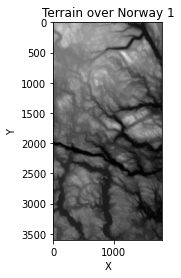

In [6]:
# Load the terrain
terrain1 = imread('SRTM_data_Norway_1.tif')

print(terrain1.shape)
# Show the terrain
plt.figure()
plt.title('Terrain over Norway 1')
plt.imshow(terrain1, cmap='gray')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

(500, 250)
prim  7
seco  7
3500
ter (500, 250)
(125000,)
(125000, 21)
(125000,)
The R2 value for a polynomial of order 5, OLS test: 0.5349148599232729
The MSE value for a polynomial of order 5, OLS test: 42558.87184694099

The R2 value for a polynomial of order 5, OLS train: 0.534380789672845
The MSE value for a polynomial of order 5, OLS train: 42718.30560083487


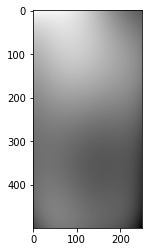

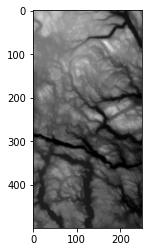

In [9]:
# np.random.seed(2020)

newLength = 500
x1 = np.linspace(0,5,np.int(newLength/2))
x2 = np.linspace(0,10,newLength)
x1, x2 = np.meshgrid(x1,x2)
print(x1.shape)

primStep = np.floor(1/newLength*3601).astype(int)
print("prim ", primStep)
secoStep = np.floor(1/np.int(newLength/2)*1801).astype(int)
print("seco ", secoStep)

term1 = primStep*x1.shape[0]
term2 = secoStep*x1.shape[1]

print(term1)
ter = terrain1[1:term1:primStep, 1:term2:secoStep]
print("ter", ter.shape)
y = ter.ravel()
print(y.shape)
degree = 5
X = createDesignMatrix(x1,x2,degree)
print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
X_train, X_test = Scale(X_train, X_test)

beta = np.linalg.pinv(X_train.T.dot(X_train)).dot(X_train.T).dot(y_train)
y_tilde = (X_train @ beta)
y_pred = (X_test @ beta)

scaler = StandardScaler()
scaler.fit(X[:,1:])
X[:,1:] = scaler.transform(X[:,1:])

beta = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(y)
y_new = (X @ beta)
print(y_new.shape)
plt.figure()
plt.imshow(y_new.reshape(newLength,(np.int(newLength/2))), cmap='gray')
plt.figure()
plt.imshow(ter.reshape((newLength,np.int(newLength/2))), cmap='gray')
print(f"The R2 value for a polynomial of order {degree}, OLS test: {R2(y_test, y_pred)}")
print(f"The MSE value for a polynomial of order {degree}, OLS test: {MSE(y_test, y_pred)}")
print(f"\nThe R2 value for a polynomial of order {degree}, OLS train: {R2(y_train, y_tilde)}")
print(f"The MSE value for a polynomial of order {degree}, OLS train: {MSE(y_train, y_tilde)}")

The R2 value for a polynomial of order 25, OLS test: 0.9801297695931904
The MSE value for a polynomial of order 25, OLS test: 459.56171685985754

The R2 value for a polynomial of order 25, OLS train: 0.9802218463653781
The MSE value for a polynomial of order 25, OLS train: 451.53884277315785


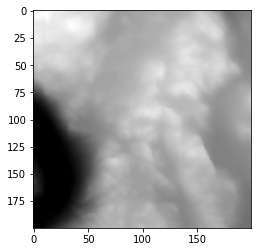

In [34]:
# np.random.seed(2020)

newLength = 200
startingPoint = 100
x1 = np.linspace(0,1,newLength)
x2 = np.linspace(0,1,newLength)
x1, x2 = np.meshgrid(x1,x2)

croppedTerrain = terrain1[startingPoint:newLength+startingPoint, startingPoint:newLength+startingPoint]
y = croppedTerrain.ravel()

degree = 25
X = createDesignMatrix(x1,x2,degree)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
X_train, X_test = Scale(X_train, X_test)

_ = olsRegression(X_train, X_test, y_train, False)

# scaler = StandardScaler()
# scaler.fit(X[:,1:])
# X[:,1:] = scaler.transform(X[:,1:])

# beta = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(y)
# y_new = (X @ beta)

# plt.figure()
# plt.imshow(y_new.reshape(newLength,newLength), cmap='gray')
plt.figure()
plt.imshow(croppedTerrain, cmap='gray')

In [ ]:
newLength = 200
startingPoint = 100
x1 = np.linspace(0,1,newLength)
x2 = np.linspace(0,1,newLength)
x1, x2 = np.meshgrid(x1,x2)
K = [5, 10]
nlambdas = 4


croppedTerrain = terrain1[startingPoint:newLength+startingPoint, startingPoint:newLength+startingPoint]
y = croppedTerrain.ravel()

degree = 25
X = createDesignMatrix(x1,x2,degree)

# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
# X_train, X_test = Scale(X_train, X_test)
p = np.random.permutation(X.shape[0])
X = X[p]
y = y[p]

print("Cross validation with ridge:")
CrossValidation("ridge", X, y)

print("Cross validation with lasso:")
CrossValidation("lasso", X, y)